In [1]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from joblib import Parallel, delayed
from tqdm import tqdm

base_dir = '/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad'
pheno = pd.read_csv(base_dir + '/signatures.csv')
orig_diff = nib.load(base_dir + '/all_data.nii')
mask = nib.load(base_dir + '/full_masked_10_percent.nii')

# convert x to categorical and get integer representation
pheno['plc_induction'] = pheno['Conditioning'].astype('category').cat.codes
pheno['Rating_diff'] = -1*pheno['Rating_diff']   # higher score stronger placebo

In [2]:
def img2vector(image_4d, mask=None):
    """
    :param image_4d: 4d numpy.array of shape (nx, ny, nz, num_samples)
    :param mask: 3d numpy array (nx, ny, nz)
    :return: numpy.array (num_samples, n_within_mask_voxels)
    """
    if mask is not None:
        vectorized = image_4d[mask>0].transpose()
    else:
        vectorized = image_4d.reshape(-1, image_4d.shape[-1]).transpose()
    return vectorized
    
        
def vector2img(vectorized_data, out_shape, mask=None):
    """
    :param vectorized_data: (num_samples, n_features)
    :param out_shape: (nx, ny, nz, num_samples)
    :param mask: 3d numpy array (nx, ny, nz)
    :return: 4d numpy.array of shape (nx, ny, nz, num_samples)
    """
    nx, ny, nz, num_samples = out_shape
    if mask is not None:
        # Create an empty array with the desired output shape
        image_4d = np.zeros(out_shape)
        
        # Get the indices of the mask where the value is greater than 0
        mask_indices = np.where(mask > 0)
        
        # Reconstruct the image from the vectorized data
        for i in range(num_samples):
            temp_image = np.zeros((nx, ny, nz))
            temp_image[mask_indices] = vectorized_data[i]
            image_4d[:, :, :, i] = temp_image
    else:
        # If no mask is provided, reshape the data to the output shape
        image_4d = vectorized_data.T.reshape(out_shape)
    
    return image_4d

In [3]:
def rank_harmonize(data, batch_id, pb=False):
    """
    :param data: n_samples x n_features
    :param batch_id:  n_samples
    :param pb: switch progressbar on/off
    :return: within-batch zero preserving rank harmonized data
    """
    output = np.zeros(data.shape)
    pbar = tqdm(np.unique(batch_id), disable=not pb)
    for batch in pbar:
        pbar.set_description(f'Batch: {batch}')
        # get the data for this batch
        data_batch = data[batch_id == batch, :]
        # for each voxel, determine the ratio if participants with negative values
        ratio_neg = np.sum(data_batch<0, axis=0)/data_batch.shape[0]
        # do a normalized, zero-preserving rank transformation
        ranked = ((rankdata(data_batch, method='average', axis=0)-0.5)/data_batch.shape[0] - ratio_neg)
        output[batch_id == batch, :] = ranked
    pbar.set_description(f'Done!')
    return output

In [4]:
data = img2vector(orig_diff.get_fdata(), mask=mask.get_fdata())
data.shape

(409, 191118)

In [5]:
rank_harmonized = rank_harmonize(data, pheno.Study_ID, pb=True)

Batch: zeidan: 100%|██████████| 16/16 [00:02<00:00,  5.74it/s]   


In [6]:
rank_harmonized_4d = vector2img(data, out_shape=orig_diff.get_fdata().shape, mask=mask.get_fdata())
# write back rank_harmonized to a 4d nifti
nib.save(nib.Nifti1Image(rank_harmonized_4d, orig_diff.affine), base_dir + '/all_data_studyranked.nii')

In [7]:
#                                                 M
#                                            (a) / \ (b)
#                                               /   \   
#                                              X ---- Y
#                                                (c)
# x, y: n_samples
# covar: n_samples x n_covariates
# m:  n_samples x n_features
def mediation(x, y, m, covar=None, y_type='continuous', m_type='continuous'):
    from sklearn.linear_model import LinearRegression, LogisticRegression
    from sklearn.multioutput import MultiOutputRegressor
    
    if covar is None:
        covar = np.array([])
        
    # M ~ X + covar
    if m_type == "continuous":
        XM = LinearRegression().fit(X=np.c_[x,covar], y=m).coef_[:,0]
    else:
        XM = MultiOutputRegressor(LogisticRegression()).fit(X=np.c_[x,covar], y=m).coef_[:,0]
        
    if y_type == "continuous":
        # Y ~ M + covar
        MY = np.array([LinearRegression().fit(X=np.c_[m[:,i],covar], y=y).coef_[0] for i in range(m.shape[1])])
        # Average Total Effects (Y ~ X + covar)
        XY = LinearRegression().fit(X=np.c_[x,covar], y=y).coef_[0]
        # Average Direct Effects (Y ~ X + M + covar)
        XMY = np.array([LinearRegression().fit(X=np.c_[x,m[:,i],covar], y=y).coef_[1] for i in range(m.shape[1])])
        
    else:
        MY = LogisticRegression().fit(X=np.c_[m,covar], y=y)    
    return XM * XMY, XM, MY, XY, XMY    

In [8]:
%%time
ACME, XM, MY, XY, XMY = mediation(x=pheno['plc_induction'].to_numpy(),
                                  y=pheno['Rating_diff'].to_numpy(),
                                  m=rank_harmonized,
                                  covar = pheno[['Age','Male']].to_numpy(),
                                  m_type='continuous')

CPU times: user 1min 8s, sys: 6.66 s, total: 1min 15s
Wall time: 1min 8s


In [9]:
ACME

array([-0.06542304, -0.02941457, -0.1509606 , ...,  0.04381365,
        0.04788685,  0.03241497])

In [10]:
# bootstrap within studies
def bootstrap_workhorse(data, pheno, batch_id, stat_fun, random_state=None):
    """
    Generates a single bootstrap sample from data and pheno, so that bootstrapping is done within batches.
    Then calls stat_fun with the bootstrapped data and pheno variables.
    :param data: numpy array of shape (n_samples, n_features)
    :param pheno: pandas dataframe of shape (n_samples,n_phenotypes)
    :param batch_id: numpy array of shape (n_samples,)
    :param stat_fun: function to be called with the bootstrapped sample. It is aware of pheno columns.
    :param random_seed: int or None, random seed for reproducibility
    :return: whatever stat_fun returns on the bootstrapped sample
    """
    # Set the random seed in a thread-safe manner
    if random_state is not None:
        random = np.random.RandomState(random_state) 
    # Lists to store bootstrapped samples
    bootstrapped_data = []
    bootstrapped_pheno = []
    # Bootstrap within each batch
    for batch in np.unique(batch_id):
        # Get indices of samples in the current batch
        batch_indices = np.where(batch_id == batch)[0]
        # Bootstrap sample indices with replacement
        sampled_indices = random.choice(batch_indices, size=len(batch_indices), replace=True)   
        # Append the bootstrapped samples to the lists
        bootstrapped_data.append(data[sampled_indices,:])
        bootstrapped_pheno.append(pheno.iloc[sampled_indices,:])  
    # Concatenate the bootstrapped samples from all batches
    bootstrapped_data = np.concatenate(bootstrapped_data, axis=0)
    bootstrapped_pheno = pd.concat(bootstrapped_pheno)
    # Call the stat_fun with the bootstrapped data and pheno
    return stat_fun(bootstrapped_data, bootstrapped_pheno)

In [80]:
%%time

def stat_fun(data, pheno):
    rank_harmonized = rank_harmonize(data, pheno.Study_ID, pb=False)
    return mediation(x=pheno['plc_induction'].to_numpy(),
                     y=pheno['Rating_diff'].to_numpy(),
                     m=rank_harmonized,
                     covar = pheno[['Age','Male']].to_numpy(),
                     m_type='continuous')

seed = 42 # for reproducibility
n_boot = 100

boot_ACME, boot_XM, boot_MY, boot_XY, boot_XMY = zip(* Parallel(n_jobs=-1, timeout=99999)(delayed(
    bootstrap_workhorse)(data, pheno, pheno.Study_ID, stat_fun, [i, seed]) for i in range(n_boot)))

CPU times: user 1.41 s, sys: 2.12 s, total: 3.52 s
Wall time: 12min 33s


In [ ]:
# save boot_ACME, boot_XM, boot_MY, boot_XY, boot_XMY


In [65]:
boot_ACME = np.array(boot_ACME)
bootstrapped_pvals_gt0 = np.zeros(boot_ACME.shape[1])
bootstrapped_pvals_twotailed = np.zeros(boot_ACME.shape[1])
for voxel_idx in range(np.array(boot_ACME).shape[1]):
    bootstrapped_pvals_gt0[voxel_idx] = np.sum(boot_ACME[:,voxel_idx]>=0)/boot_ACME.shape[0]
    # convert to two tailed
    if bootstrapped_pvals_gt0[voxel_idx] > 0.5:
        bootstrapped_pvals_twotailed[voxel_idx] = 1 - bootstrapped_pvals_gt0[voxel_idx]
    else:
        bootstrapped_pvals_twotailed[voxel_idx] = bootstrapped_pvals_gt0[voxel_idx]
    bootstrapped_pvals_twotailed[voxel_idx] *= 2
    
bootstrapped_pvals_twotailed

array([0.764, 0.878, 0.532, ..., 0.832, 0.844, 0.868])

(array([91837]),)

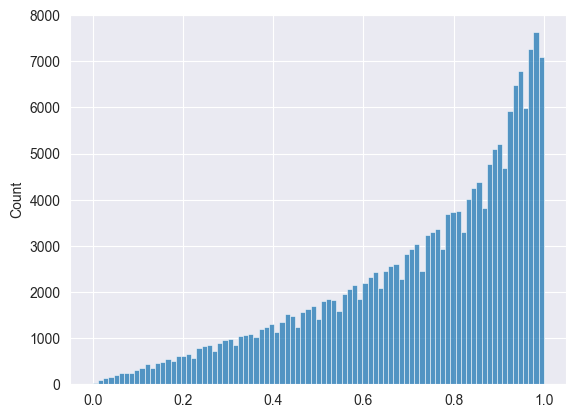

In [66]:
sns.histplot(bootstrapped_pvals_twotailed)
np.where(bootstrapped_pvals_twotailed==0)

<Axes: ylabel='Count'>

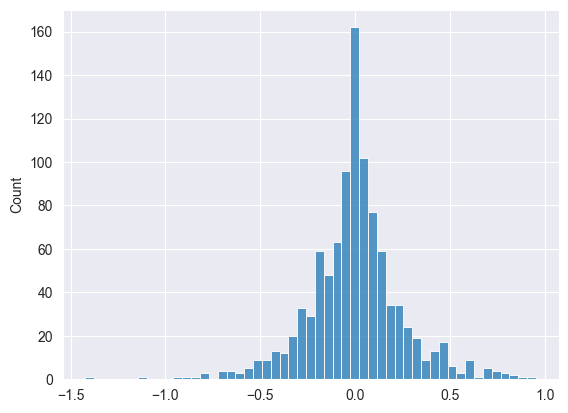

In [70]:
sns.histplot(boot_ACME[:,5000])

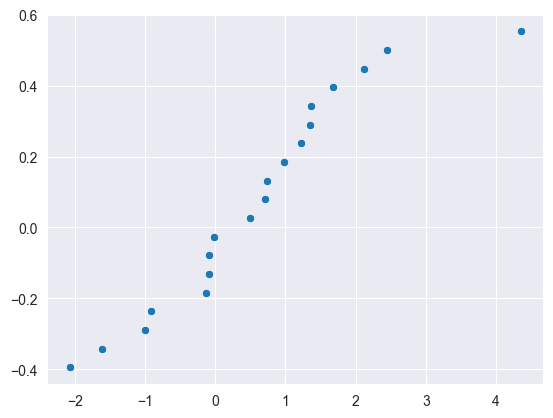

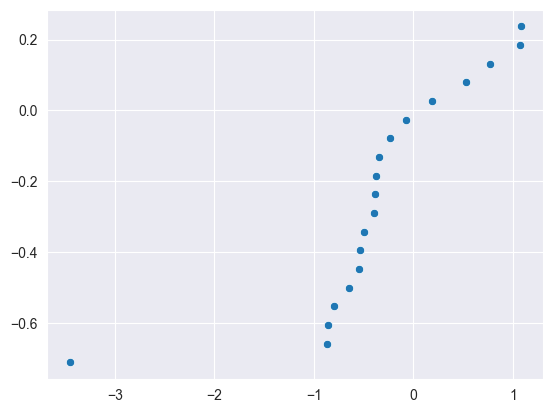

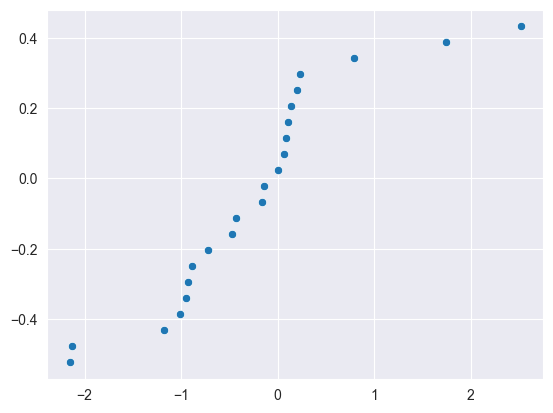

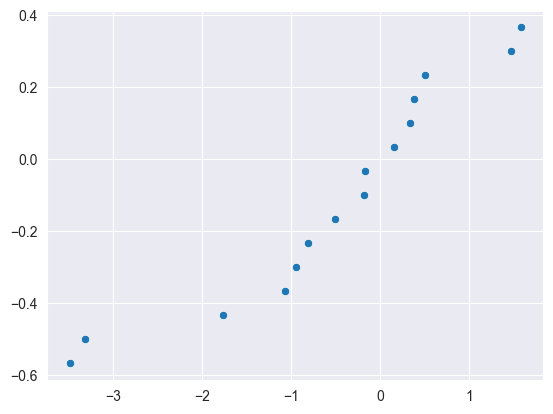

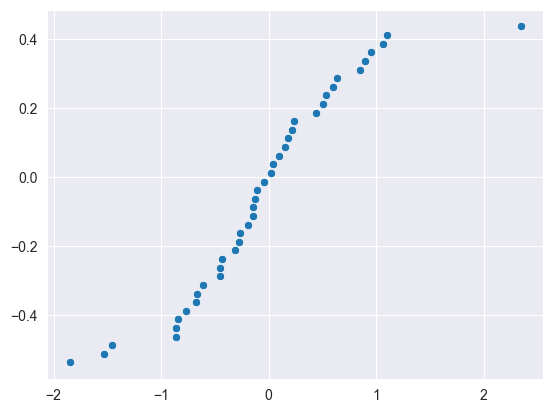

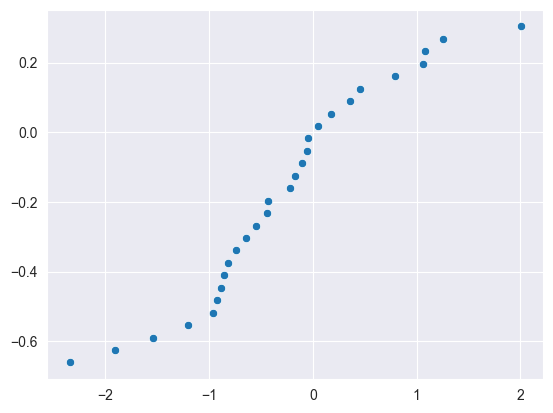

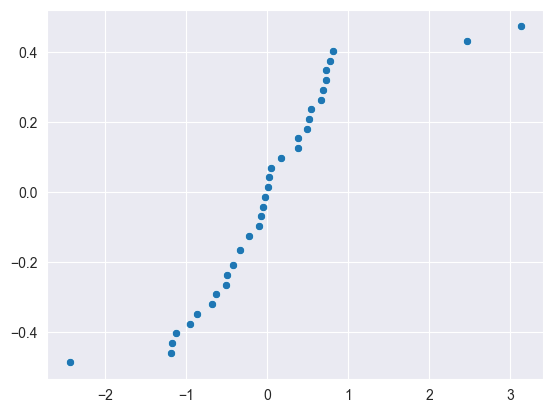

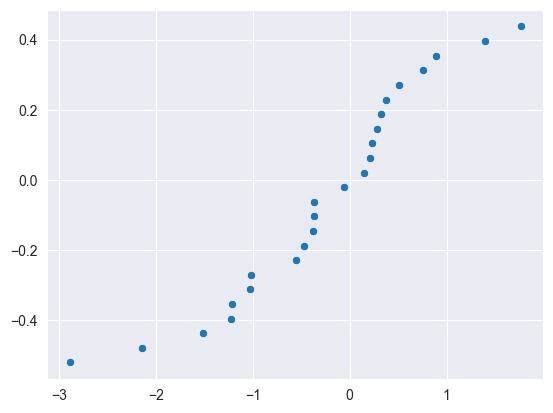

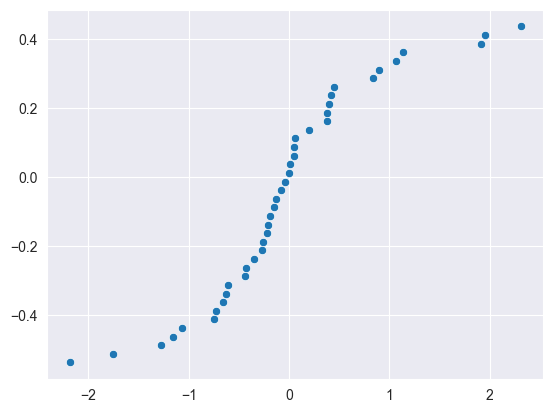

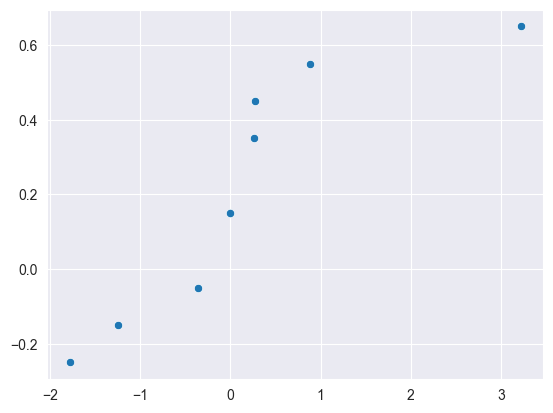

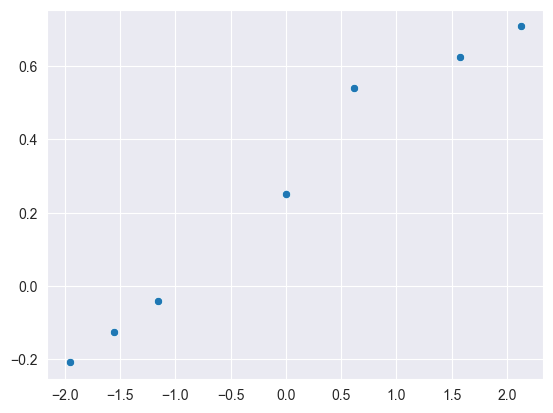

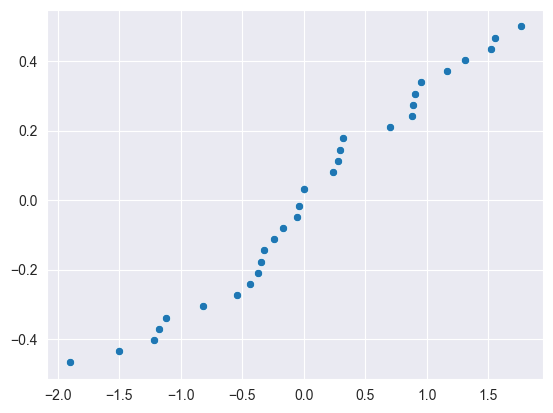

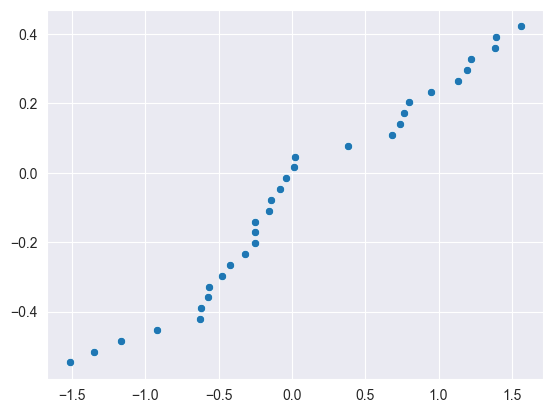

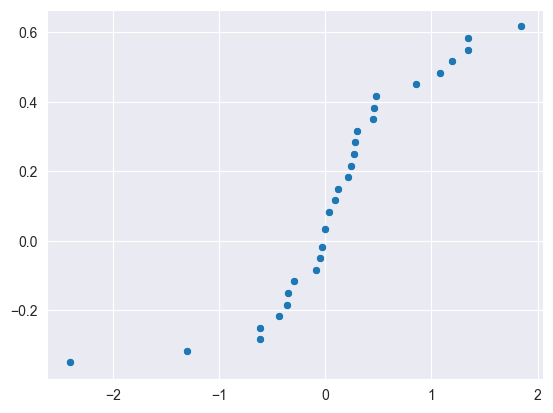

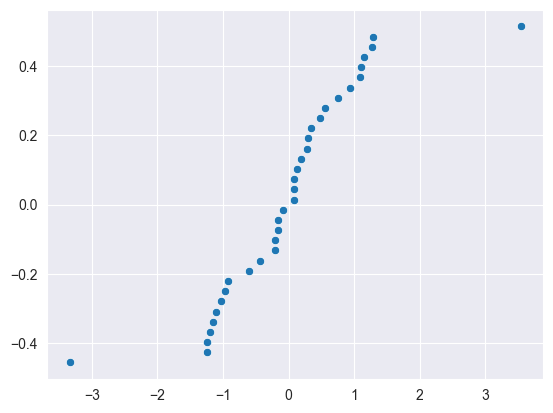

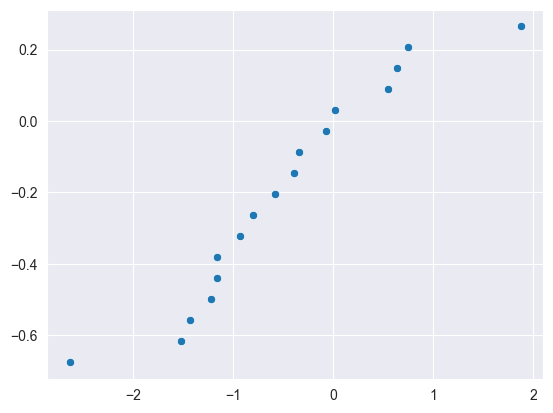

In [79]:
for batch in np.unique(pheno.Study_ID):
    # get the data for this batch
    data_batch_harm = rank_harmonized[pheno.Study_ID == batch, :]
    data_batch = data[pheno.Study_ID == batch, :]
    sns.scatterplot(x=data_batch[:, 10], y=data_batch_harm[:, 10])
    plt.show()